In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, exp, pi, erfc, gamma
import scipy
from tqdm import tqdm
from scipy.integrate import simpson
import math

from win32com.client import constants

x_0_sampled = True

_k_b = scipy.constants.k
_rho = 4200
_rho_f = 790

_r =  1.290153649828586e-06
_gain = np.sqrt(450696654238001.6)
_K = 6.746007702007992e-05

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_eta = 0.32e-3
_gamma = 6 * np.pi * _r * _eta
z = 6*_r**2*np.sqrt(np.pi * _eta * _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def experfc_inverse_form(t, tau, roots):
    return np.real((1/_m) * sum(
        (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((_k_b*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

def x_t1_x_t2_x_thermal(t1, t2, m, K, radius, eta, rho_f, v0):
    gamma = 6*np.pi*radius*eta
    return ensemble_r_term(t1, t2, m, K, roots) + (_k_b*_temp/_K)*(m**2*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) + m*gamma*a_inverse_form(t1,roots)*b_inverse_form(t2,roots)+m*gamma*a_inverse_form(t2,roots)*b_inverse_form(t1,roots)+m*gamma*radius*np.sqrt(rho_f/eta)*a_inverse_form(t1,roots)*s_half_b_inverse_form(t2, roots)+m*gamma*radius*np.sqrt(rho_f/eta)*a_inverse_form(t2,roots)*s_half_b_inverse_form(t1, roots)+gamma**2*b_inverse_form(t1, roots)*b_inverse_form(t2, roots)+gamma**2*radius**2*(rho_f/eta)*s_half_b_inverse_form(t1, roots)*s_half_b_inverse_form(t2, roots) + gamma**2*radius*np.sqrt(rho_f/eta)*b_inverse_form(t1, roots)*s_half_b_inverse_form(t2, roots)+gamma**2*radius*np.sqrt(rho_f/eta)*b_inverse_form(t2, roots)*s_half_b_inverse_form(t1, roots))+m**2*v0**2*b_inverse_form(t1, roots)*b_inverse_form(t2, roots)

def full_hydro_msd_x_thermal(t1, t2, m, K, radius, eta, rho_f, v0):
    return x_t1_x_t2_x_thermal(t1, t1, m, K, radius, eta, rho_f, v0) + x_t1_x_t2_x_thermal(t2, t2, m, K, radius, eta, rho_f, v0) - 2 * x_t1_x_t2_x_thermal(t1, t2, m, K, radius, eta, rho_f, v0)

def stat_hydro_msd(t, roots):
    return 2*constants.k*_temp*c_inverse_form(t, roots)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _eta, _rho_f)


# History term in Laplace domain - see overleaf doc
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 1/sqrt(-tau) - 1 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))


def cross_correlation(series1, series2, dt):
    if(len(series1) != len(series2)):
        print("series1 has " + str(len(series1)))
        print("series2 has " + str(len(series2)))
        return 0
    n = len(series1)
    cc = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in tqdm(np.array(range(1, n, 1))):
        cc_tau = series1[tau:]*series2[:n - tau]
        cc[tau] = np.mean(cc_tau)
    cc[0] = 0
    return cc, lag_times


def get_basset_int(a_series, start_idx):
    max_tau = start_idx
    lags = np.arange(1, max_tau+1)[::-1]/fs_sim
    basset_integral = []
    for curr_idx in tqdm(range(start_idx, len(a_series))):
        curr_integral = simpson(a_series[curr_idx-max_tau:curr_idx]/np.sqrt(lags), x=lags[::-1])
        basset_integral.append(curr_integral)
    return basset_integral


def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

def get_acceleration(velocity, dt):
    acceleration = np.zeros_like(velocity)

    # Use forward difference at the first point
    acceleration[0] = (velocity[1] - velocity[0]) / dt

    # Use centered difference for the middle points
    acceleration[1:-1] = (velocity[2:] - velocity[:-2]) / (2 * dt)

    # Use backward difference at the last point
    acceleration[-1] = (velocity[-1] - velocity[-2]) / dt

    return acceleration

Set v_0

In [2]:
v_not = 2 * np.sqrt(_k_b * _temp / _m)

Get the analytic form

In [3]:

times_analytic = np.logspace(-9, -1.5, 100)
roots = compute_roots(_m, _K, _r, _eta, _rho_f)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 10000


# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results_zero_no_half = np.zeros((num_samples, len(times_analytic)))
speeds_analytic = 0
zero_analytic = 0
if x_0_sampled:
    for i in range(num_samples):
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, initial_conditions_x[i], v_not)
        results_zero_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, initial_conditions_x[i],0)
    speeds_analytic=results_speed_no_half.mean(axis=0)
    zero_analytic=results_zero_no_half.mean(axis=0)
else:
    speeds_analytic = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, 0, v_not)
    zero_analytic = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, 0, 0)


PARAMS TO CHANGE

In [4]:
# High precision for inverse Laplace
mp.dps = 20

# Time grid (log-spaced in negative time)
tau_min = 1e-12
tau_max = 1e-1

# Number of tau points
N = 100

# Number of time (forward points)
points = 40


SETUP

In [5]:
# CHECK IF FILE EXISTS THEN RUN IF NEEDED

import os
chunksize = 10 ** 6  # Adjust chunk size based on your memory availability

import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson

trace_num=30

#Keep below 5
cut_factor = 1
bin_num_sim = 15
all_positions = []
all_velocities = []

all_final_positions = []
all_final_velocities = []
all_final_accelerations = []
all_final_basset = []
all_final_r_series = []

load=True

for t in range(trace_num):
    chunks = []
    for chunk in pd.read_csv(rf'C:\Users\Cole Thumann\Desktop\Lab_Repos\MarkovianEmbedding\trace_{t}.csv', chunksize=chunksize, low_memory=False):
        # process each chunk individually or filter/aggregate it
        chunks.append(chunk)
    
    df = pd.concat(chunks, ignore_index=True)
    
    # Extract only the columns that start with 'Position' or 'Velocity'
    position_cols = [col for col in df.columns if col.startswith('Position')]
    velocity_cols = [col for col in df.columns if col.startswith('Velocity')]
    
    # FIX THIS
    # timestep_sim = df['real_timestep_s'].values[0]
    timestep_sim=5.311e-10
    positions_sim = []
    velocities_sim = []
    for i in range(len(position_cols)):
        positions_sim.append(df[position_cols[i]].astype(float).values)
        velocities_sim.append(df[velocity_cols[i]].astype(float).values)
    length = len(positions_sim)
    # CUT THE TRACES DOWN
    all_positions.append([trace[:int(len(trace)/cut_factor)] for trace in positions_sim])
    all_velocities.append([trace[:int(len(trace)/cut_factor)] for trace in velocities_sim])

    fs_sim = 1/(timestep_sim * bin_num_sim)

    if os.path.exists(f"saved_traces_{t}.txt") and load:
        print("LOADING ACCELERATION AND RANDOM FORCE")
        # Load from text file
        loaded_data = np.loadtxt(f"saved_traces_{t}.txt", skiprows=1)  # Skip header
    
        # Extract columns
        all_final_accelerations.append(loaded_data[:, 0])
        all_final_velocities.append(loaded_data[:, 1])
        all_final_positions.append(loaded_data[:, 2])
        all_final_basset.append(loaded_data[:, 3])
        all_final_r_series.append(loaded_data[:, 4])


    else:
    
        print("FINDING ACCELERATION AND RANDOM FORCE")
    
        traces_sim = 0
        traces_sim= []
        for trace in positions_sim:
            series = bin_data(trace, bin_num_sim)
            traces_sim.append(series)
    
        times = np.arange(len(traces_sim[0]))/fs_sim
    
        print("len of traces is " + str(len(traces_sim[0])))
    
        v_traces_sim = []
        for trace in velocities_sim:
            series = bin_data(trace, bin_num_sim)
            v_traces_sim.append(series)
    
        a_traces_sim = []
        for trace in v_traces_sim:
            series = get_acceleration(trace, times[1]-times[0])
            a_traces_sim.append(series)
    
        tau_max_idx = int(.001*fs_sim)
        bass = np.array(get_basset_int(a_traces_sim[0], tau_max_idx))
        
        all_final_basset.append(bass)
        r_series = []
    
        all_final_positions.append(np.array(traces_sim[0])[tau_max_idx:])
        all_final_velocities.append(np.array(v_traces_sim[0])[tau_max_idx:])
        all_final_accelerations.append(np.array(a_traces_sim[0])[tau_max_idx:])
    
        # We pick .001 as the max tau (how far back to begin calculating history - as it gives roughly 1% the value of 1/sqrt(1e-7) which is our min tau)
    
        all_final_r_series.append(_m*all_final_accelerations[t]+_gamma*all_final_velocities[t]+_K*all_final_positions[t]+z*bass)

        data_to_save = np.column_stack((
            all_final_accelerations[t],
            all_final_velocities[t],
            all_final_positions[t],
            all_final_basset[t],
            all_final_r_series[t]
        ))
    
        # Save to text file
        np.savetxt(f"saved_traces_bin15{t}.txt", data_to_save, header="acceleration velocity position bass r_series")


LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCELERATION AND RANDOM FORCE
LOADING ACCE

In [7]:
init_len_data = int(len(all_final_positions[0])/100)
times = np.arange(len(all_final_positions[0]))/fs_sim

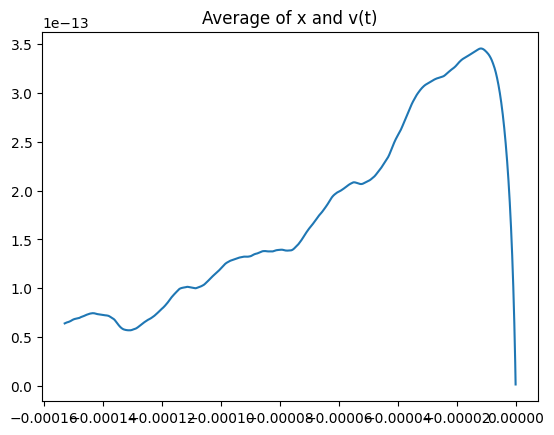

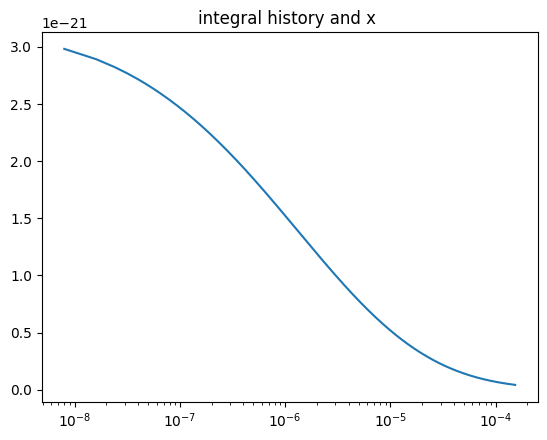

6.178534986134593e-16


100%|██████████| 30/30 [11:07<00:00, 22.23s/it]


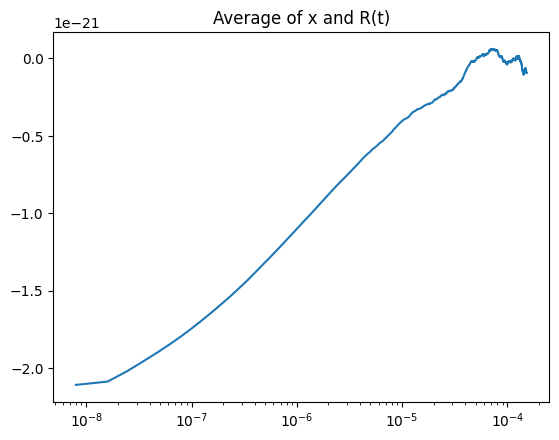

In [8]:

#
# # x0xv(t)
# sum_x_v_t = np.zeros(init_len_data)
# i_3 = 0
# for idx in range(1, len(positions)-init_len_data):
#     sum_x_v_t += velocities[idx:idx+init_len_data]*positions[idx]
#     i_3+=1
#
# X_2_2 = np.arange(1, init_len_data+1)*1/fs_sim
# avg_x_v_t = sum_x_v_t/i_3
# plt.plot(X_2_2, avg_x_v_t)
# # plt.plot(times[3:10000], -(1/2)*np.array(times[3:10000])**(-1.5)*_gamma*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label = "3/2")
# plt.title("Average of x and v(t)")
# # plt.xscale("log")
# # plt.yscale("log")
# plt.show()

#EQuluilibrimmmm

# x0xv(t)
sum_x_v_t = np.zeros(init_len_data)
i_3 = 0
for trace in range(len(all_final_velocities)):
    for idx in range(init_len_data, len(all_final_positions[0])):
        sum_x_v_t += all_final_velocities[0][idx-init_len_data:idx]*all_final_positions[0][idx]
        i_3+=1

X_2_2 = -np.arange(1, init_len_data+1)[::-1]*1/fs_sim
avg_x_v_t = sum_x_v_t/i_3
plt.plot(X_2_2, avg_x_v_t)
# plt.plot(times[3:10000], -(1/2)*np.array(times[3:10000])**(-1.5)*_gamma*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label = "3/2")
plt.title("Average of x and v(t)")
# plt.xscale("log")
# plt.yscale("log")
plt.show()

# Do the integral
result_history_x = []
time_array_pos = np.arange(1, init_len_data+1)*1/fs_sim
for time in time_array_pos:
    integrand_3 = _gamma*_r*np.sqrt(_rho_f/(_eta*np.pi))*avg_x_v_t*(1/(2*(time-X_2_2)**(3/2)))
    res = simpson(integrand_3, X_2_2)
    result_history_x.append(res)

plt.plot(time_array_pos, result_history_x)
# plt.plot(times[3:10000], -(1/2)*np.array(times[3:10000])**(-1.5)*_gamma*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label = "3/2")
plt.title("integral history and x ")
plt.xscale("log")
# plt.yscale("log")
plt.show()

# x0xv(0)
sum_x_v_t = 0
i_3 = 0
for trace in range(len(all_final_velocities)):
    for idx in range(init_len_data, len(all_final_positions[trace])):
        sum_x_v_t += all_final_velocities[trace][idx]*all_final_positions[trace][idx]
        i_3+=1

X_2_2 = np.arange(1, init_len_data+1)*1/fs_sim
avg_x_v_t = sum_x_v_t/i_3
print(avg_x_v_t)

# x0xR(t)
sum_x_R_t = np.zeros(init_len_data)
i_3 = 0
for trace in tqdm(range(len(all_final_r_series))):
    for idx in range(len(all_final_positions[trace])-init_len_data):
        sum_x_R_t += all_final_r_series[trace][idx:idx+init_len_data]*all_final_positions[trace][idx]
        i_3+=1

X_2_2 = np.arange(1, init_len_data+1)*1/fs_sim
avg_x_R_t = sum_x_R_t/i_3
plt.plot(X_2_2, avg_x_R_t)
# plt.plot(times[3:10000], -(1/2)*np.array(times[3:10000])**(-1.5)*_gamma*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label = "3/2")
plt.title("Average of x and R(t)")
plt.xscale("log")
# plt.yscale("log")
plt.show()



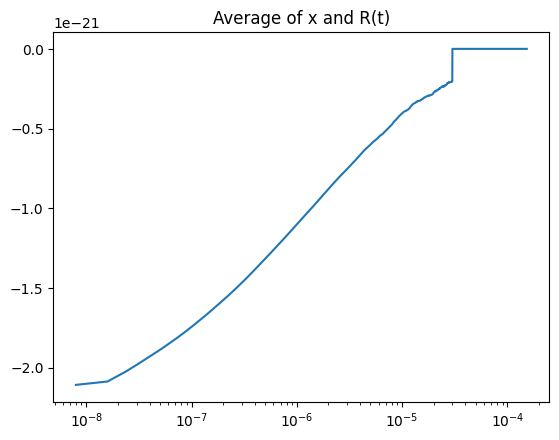

In [22]:

masked_x_R_t = np.where(X_2_2>3e-5, 0, avg_x_R_t)
plt.plot(X_2_2, masked_x_R_t)
# plt.plot(times[3:10000], -(1/2)*np.array(times[3:10000])**(-1.5)*_gamma*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label = "3/2")
plt.title("Average of x and R(t)")
plt.xscale("log")
# plt.yscale("log")
plt.show()

100%|██████████| 19218/19218 [06:11<00:00, 51.75it/s]


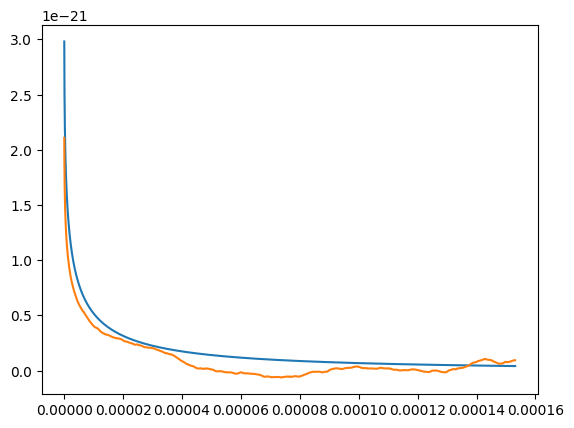

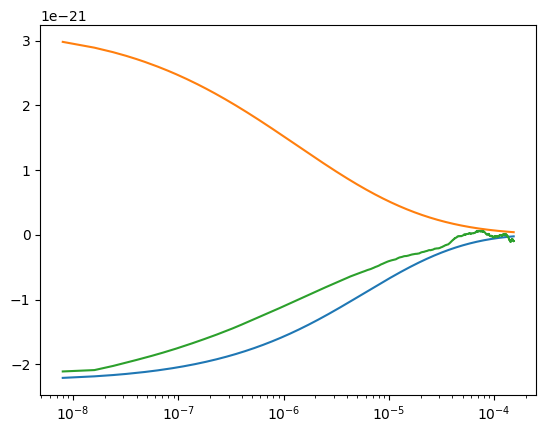

In [9]:

# analytic
result_analytic = []
tau_analytic = -time_array_pos[::-1]
for time in tqdm(time_array_pos):
    integrand_4 = -1*b_inverse_form(time-tau_analytic, roots)*2*_gamma*_k_b*_temp*(1/4)*_r*np.sqrt(_rho_f/(_eta*np.pi))*(time-tau_analytic)**(-3/2)
    res = simpson(integrand_4, tau_analytic)
    result_analytic.append(res)

#Both plot

plt.plot(time_array_pos, result_history_x)
plt.plot(X_2_2, -avg_x_R_t)
plt.show()

plt.plot(time_array_pos, result_analytic)
plt.plot(time_array_pos, result_history_x)
plt.plot(X_2_2, avg_x_R_t)
plt.xscale("log")
plt.show()

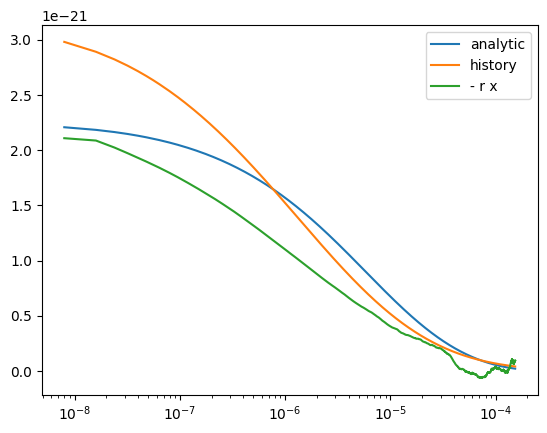

In [10]:

plt.plot(time_array_pos, -1*np.array(result_analytic), label="analytic")
plt.plot(time_array_pos, result_history_x, label="history")
plt.plot(X_2_2, -avg_x_R_t, label="- r x")
plt.legend()
plt.xscale("log")
plt.show()

In [11]:
#Plot the normal MSD for the zero case

times_analytic = np.logspace(-8,-3, 200)
zero_speed_msd = full_hydro_msd_x_thermal(0, times_analytic, _m, _K, _r, _eta, _rho_f, 0)
one_speed = full_hydro_msd_x_thermal(0, times_analytic, _m, _K, _r, _eta, _rho_f, np.sqrt(_k_b*_temp/_m))

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)

num_samples = 1000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed = np.zeros((num_samples, len(times_analytic)))
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results = np.zeros((num_samples, len(times_analytic)))

speeds_analytic_no_half = []

print("Speed X")
for i in range(num_samples):
    results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, initial_conditions_x[i], 0)
speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))


Speed X


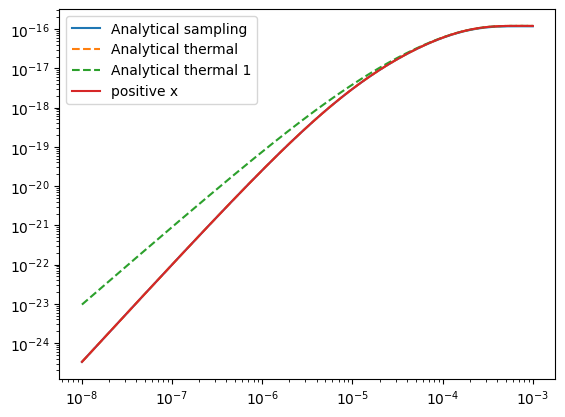

In [12]:

zero_speed_msd_positive_pos = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, np.sqrt(_k_b*_temp/_K), 0)
two = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, 0, 0)
plt.plot(times_analytic, speeds_analytic_no_half[0], label=f"Analytical sampling")
plt.plot(times_analytic, zero_speed_msd, linestyle='dashed', label=f"Analytical thermal")
plt.plot(times_analytic, one_speed, linestyle='dashed', label=f"Analytical thermal 1")
plt.plot(times_analytic, zero_speed_msd_positive_pos, label=f"positive x")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [29]:
#Calculate the 6 terms
def term1(t1, t2):
    mask = time_array_pos < t2
    mask_r = X_2_2 < t2
    # r_x = avg_x_R_t[mask_r]
    r_x = masked_x_R_t[mask_r]
    times = time_array_pos[mask]
    
    integrand = b_inverse_form(t2-times, roots)*r_x
    return _m*a_inverse_form(t1, roots)*simpson(integrand, times)

def term2(t1, t2):
    mask = time_array_pos < t2
    mask_h = time_array_pos < t2
    h_x = np.array(result_history_x)[mask_h]
    times = time_array_pos[mask]
    
    integrand = b_inverse_form(t2-times, roots)*h_x
    return _m*a_inverse_form(t1, roots)*simpson(integrand, times)

def term3(t1, t2):
    mask = time_array_pos < t2
    mask_r = X_2_2 < t2
    r_x = masked_x_R_t[mask_r]
    times = time_array_pos[mask]
    
    integrand = b_inverse_form(t2-times, roots)*r_x
    return _gamma*b_inverse_form(t1, roots)*simpson(integrand, times)
    
def term4(t1, t2):
    mask = time_array_pos < t2
    mask_h = time_array_pos < t2
    h_x = np.array(result_history_x)[mask_h]
    times = time_array_pos[mask]
    
    integrand = b_inverse_form(t2-times, roots)*h_x
    return _gamma*b_inverse_form(t1, roots)*simpson(integrand, times)


def term5(t1, t2):
    mask = time_array_pos < t2
    mask_r = X_2_2 < t2
    r_x = masked_x_R_t[mask_r]
    times = time_array_pos[mask]
    
    integrand = b_inverse_form(t2-times, roots)*r_x
    return _gamma*_r*np.sqrt(_rho_f/_eta)*s_half_b_inverse_form(t1, roots)*simpson(integrand, times)
    
def term6(t1, t2):
    mask = time_array_pos < t2
    mask_h = time_array_pos < t2
    h_x = np.array(result_history_x)[mask_h]
    times = time_array_pos[mask]
    
    integrand = b_inverse_form(t2-times, roots)*h_x
    return _gamma*_r*np.sqrt(_rho_f/_eta)*s_half_b_inverse_form(t1, roots)*simpson(integrand, times)
# 
def all_missing1(t1, t2):
    return np.array(term1(t1, t2))+np.array(term2(t1, t2))+np.array(term3(t1, t2))+np.array(term4(t1, t2))+np.array(term5(t1, t2))+np.array(term6(t1, t2))

def all_missing2(t1, t2):
    return (
        term1(t1, t2) + term2(t1, t2) + term3(t1, t2) + term4(t1, t2) + term5(t1, t2) + term6(t1, t2) +
        term1(t2, t1) + term2(t2, t1) + term3(t2, t1) + term4(t2, t1) + term5(t2, t1) + term6(t2, t1)
    )

    
def missing_msd_terms(t1, t2):
    return all_missing2(t2, t2)-2*all_missing1(t1,t2)#+all_missing(t1, t1)
 

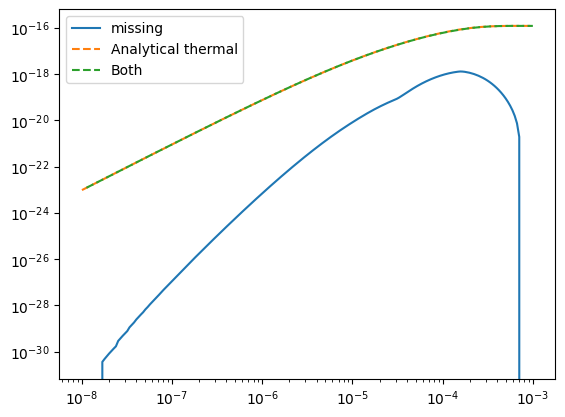

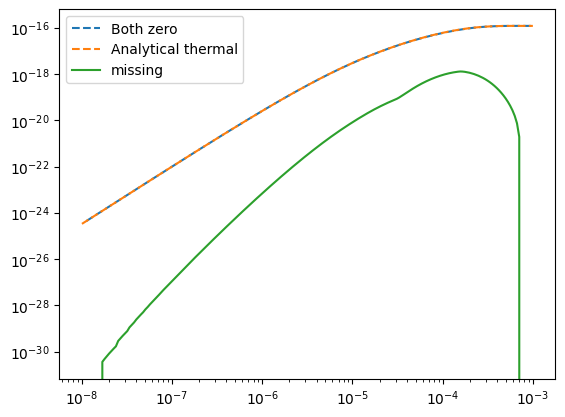

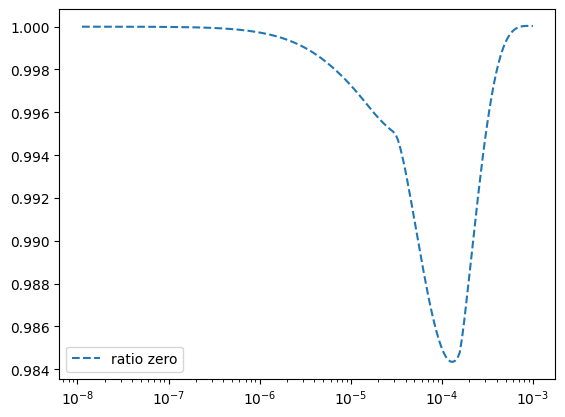

In [32]:

plot_times = times_analytic[2:]
# missing = [ missing_msd_terms(0, t) for t in plot_times ]
missing = np.array([missing_msd_terms(0, t) for t in plot_times])
plt.plot(plot_times, -1*missing, label='missing')
# 
plt.plot(times_analytic, one_speed, linestyle='dashed', label=f"Analytical thermal")
plt.plot(plot_times, missing+one_speed[2:], linestyle='dashed', label=f"Both")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(plot_times, missing+zero_speed_msd[2:], linestyle='dashed', label=f"Both zero")
plt.plot(times_analytic, zero_speed_msd, linestyle='dashed', label=f"Analytical thermal")
plt.plot(plot_times, -1*missing, label='missing')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


# plt.plot(plot_times, (missing+one_speed[2:])/one_speed[2:], linestyle='dashed', label=f"ratio one")
# plt.xscale("log")
# plt.legend()
# plt.show()

plt.plot(plot_times, (missing+zero_speed_msd[2:])/zero_speed_msd[2:], linestyle='dashed', label=f"ratio zero")
plt.xscale("log")
plt.legend()
plt.show()

with open('x_cross_terms_ratio_zero_v.dat', 'w') as f:
    f.write(f"# DATA \n")
    data = np.column_stack((plot_times, (missing+zero_speed_msd[2:])/zero_speed_msd[2:]))
    np.savetxt(f, data, fmt='%.15e')
